EfficientNet-B0 모델을 활용한 120종 강아지 품종 분류

1. 라이브러리 임포트 및 기본 경로/파라미터 설정

In [2]:
import os
import time
import xml.etree.ElementTree as ET

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from scipy.io import loadmat
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm 
import numpy as np
import matplotlib.pyplot as plt

IMAGE_BASE_PATH = r"C:\Users\JT\Desktop\images\Images"
ANNOTATION_BASE_PATH = r"C:\Users\JT\Desktop\annotation\Annotation"
LIST_BASE_PATH = r"C:\Users\JT\Desktop\lists"

IMG_SIZE = 224
BATCH_SIZE = 32
NUM_CLASSES = 120
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"사용 장치: {device}")

사용 장치: cpu


2. 데이터 로딩 및 DataFrame 생성 함수 정의

In [3]:
def load_mat_and_create_dataframe(list_file_name, image_base_path, annotation_base_path, list_base_path):
    mat_file_path = os.path.join(list_base_path, list_file_name)
    try:
        mat_data = loadmat(mat_file_path)
    except FileNotFoundError:
        print(f"오류: .mat 파일을 찾을 수 없습니다 - {mat_file_path}")
        return None
    
    file_list_arr = mat_data['file_list']
    annotation_list_arr = mat_data['annotation_list']
    labels_arr = mat_data['labels']
    
    data_for_df = []
    for i in range(len(file_list_arr)):
        img_rel_path = file_list_arr[i][0][0]
        ann_rel_path = annotation_list_arr[i][0][0]
        label_val = labels_arr[i][0]
        full_img_path = os.path.join(image_base_path, img_rel_path)
        full_ann_path = os.path.join(annotation_base_path, ann_rel_path)
        data_for_df.append({
            'image_path': full_img_path, 'annotation_path': full_ann_path, 'label': label_val,
            'image_relative': img_rel_path, 'annotation_relative': ann_rel_path
        })
    return pd.DataFrame(data_for_df)

3. 학습 및 테스트 DataFrame 생성

In [12]:
import pandas as pd
pd.set_option('display.width', 60)
pd.set_option('display.max_columns', None)


print("학습 데이터 로딩 중...")
df_train = load_mat_and_create_dataframe('train_list.mat', IMAGE_BASE_PATH, ANNOTATION_BASE_PATH, LIST_BASE_PATH)
if df_train is not None:
    print(f"df_train 생성 완료: {len(df_train)}개 샘플")
    print("--- df_train 데이터 샘플 (상위 5개) ---")
    print(df_train.head())
    print()

print("테스트 데이터 로딩 중...")
df_test = load_mat_and_create_dataframe('test_list.mat', IMAGE_BASE_PATH, ANNOTATION_BASE_PATH, LIST_BASE_PATH)
if df_test is not None:
    print(f"df_test 생성 완료: {len(df_test)}개 샘플")
    print("--- df_test 데이터 샘플 (상위 5개) ---")
    print(df_test.head())
    print()

학습 데이터 로딩 중...
df_train 생성 완료: 12000개 샘플
--- df_train 데이터 샘플 (상위 5개) ---
                                          image_path  \
0  C:\Users\JT\Desktop\images\Images\n02085620-Ch...   
1  C:\Users\JT\Desktop\images\Images\n02085620-Ch...   
2  C:\Users\JT\Desktop\images\Images\n02085620-Ch...   
3  C:\Users\JT\Desktop\images\Images\n02085620-Ch...   
4  C:\Users\JT\Desktop\images\Images\n02085620-Ch...   

                                     annotation_path  \
0  C:\Users\JT\Desktop\annotation\Annotation\n020...   
1  C:\Users\JT\Desktop\annotation\Annotation\n020...   
2  C:\Users\JT\Desktop\annotation\Annotation\n020...   
3  C:\Users\JT\Desktop\annotation\Annotation\n020...   
4  C:\Users\JT\Desktop\annotation\Annotation\n020...   

   label                           image_relative  \
0      1   n02085620-Chihuahua/n02085620_5927.jpg   
1      1   n02085620-Chihuahua/n02085620_4441.jpg   
2      1   n02085620-Chihuahua/n02085620_1502.jpg   
3      1   n02085620-Chihuahua/n02085620_

4. DogBreedDataset 클래스 정의

In [13]:
class DogBreedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx): idx = idx.tolist()
        if self.dataframe is None or self.dataframe.empty: return None, None
        try:
            row = self.dataframe.iloc[idx]
            img_path, ann_path, label_val = row['image_path'], row['annotation_path'], row['label']
        except IndexError: return None, None
        
        label = torch.tensor(label_val - 1, dtype=torch.long)
        try:
            image = Image.open(img_path).convert('RGB')
            tree = ET.parse(ann_path)
            root = tree.getroot()
            bndbox = {}
            for obj_tag in root.findall('object'):
                bndbox_tag = obj_tag.find('bndbox')
                if bndbox_tag is not None:
                    bndbox = {k: int(bndbox_tag.find(k).text) for k in ['xmin', 'ymin', 'xmax', 'ymax']}
                    break 
            if bndbox: image = image.crop((bndbox['xmin'], bndbox['ymin'], bndbox['xmax'], bndbox['ymax']))
            if self.transform: image = self.transform(image)
            return image, label
        except FileNotFoundError: return None, None
        except Exception: return None, None

5. 이미지 변환 정의

In [14]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15), transforms.ToTensor(), normalize
])
val_test_transforms = transforms.Compose([transforms.Resize((IMG_SIZE, IMG_SIZE)), transforms.ToTensor(), normalize])

6. Dataset 및 DataLoader 인스턴스 생성

In [15]:
if df_train is not None and df_test is not None:
    train_dataset = DogBreedDataset(dataframe=df_train, transform=train_transforms)
    test_dataset = DogBreedDataset(dataframe=df_test, transform=val_test_transforms)
    
    def collate_fn_skip_none(batch):
        batch = [s for s in batch if s[0] is not None and s[1] is not None]
        if not batch: return torch.empty(0), torch.empty(0)
        return torch.utils.data.dataloader.default_collate(batch)

    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, collate_fn=collate_fn_skip_none)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, collate_fn=collate_fn_skip_none)
    print(f"\n학습/테스트 Dataset 및 DataLoader 생성 완료 (배치 크기: {BATCH_SIZE})")
else:
    print("\n오류: DataFrame 로드 실패로 DataLoader 생성 불가.")
    train_dataloader, test_dataloader = None, None


학습/테스트 Dataset 및 DataLoader 생성 완료 (배치 크기: 32)


7. 모델, 손실함수, 옵티마이저 정의

In [16]:
model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, NUM_CLASSES)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
print(f"\n모델, 손실함수, 옵티마이저 정의 완료.")


모델, 손실함수, 옵티마이저 정의 완료.


8. 학습 및 평가 함수 정의

In [17]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, current_epoch_num, total_epochs, pbar_outer):
    model.train()
    running_loss, correct_predictions, total_samples, num_batches = 0.0, 0, 0, len(dataloader)

    for batch_idx, (images_batch, labels_batch) in enumerate(dataloader):
        if images_batch.nelement() == 0: continue
        images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(images_batch)
        loss = criterion(outputs, labels_batch)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images_batch.size(0)
        _, predicted_labels = torch.max(outputs, 1)
        correct_predictions += (predicted_labels == labels_batch).sum().item()
        total_samples += labels_batch.size(0)

        if total_samples > 0 and num_batches > 0 :
            progress_percentage = (batch_idx + 1) / num_batches * 100
            current_avg_loss = running_loss / total_samples
            current_avg_acc = correct_predictions / total_samples
            pbar_outer.set_postfix({
                'Epoch': f'{current_epoch_num}/{total_epochs}', 'Phase': 'Train',
                'Batch': f'{batch_idx+1}/{num_batches} ({progress_percentage:.1f}%)',
                'AvgLoss': f'{current_avg_loss:.4f}', 'AvgAcc': f'{current_avg_acc:.4f}'
            })
            
    if total_samples == 0: return 0.0, 0.0
    return running_loss / total_samples, correct_predictions / total_samples

def evaluate_model(model, dataloader, criterion, device, current_epoch_num, total_epochs, pbar_outer, phase_desc="Test"):
    model.eval()
    running_loss, correct_predictions, total_samples, num_batches = 0.0, 0, 0, len(dataloader)
    
    with torch.no_grad():
        for batch_idx, (images_batch, labels_batch) in enumerate(dataloader):
            if images_batch.nelement() == 0: continue
            images_batch, labels_batch = images_batch.to(device), labels_batch.to(device)
            outputs = model(images_batch)
            loss = criterion(outputs, labels_batch)
            running_loss += loss.item() * images_batch.size(0)
            _, predicted_labels = torch.max(outputs, 1)
            correct_predictions += (predicted_labels == labels_batch).sum().item()
            total_samples += labels_batch.size(0)

            if total_samples > 0 and num_batches > 0:
                progress_percentage = (batch_idx + 1) / num_batches * 100
                current_avg_loss = running_loss / total_samples
                current_avg_acc = correct_predictions / total_samples
                pbar_outer.set_postfix({
                    'Epoch': f'{current_epoch_num}/{total_epochs}', 'Phase': phase_desc,
                    'Batch': f'{batch_idx+1}/{num_batches} ({progress_percentage:.1f}%)',
                    'AvgLoss': f'{current_avg_loss:.4f}', 'AvgAcc': f'{current_avg_acc:.4f}'
                })

    if total_samples == 0: return 0.0, 0.0
    return running_loss / total_samples, correct_predictions / total_samples

9. 메인 학습 루프 및 결과 시각화


학습 시작... (총 10 에포크, 장치: cpu)


에포크 10/10: 100%|█| 10/10 [1:37:28<00:00, 584.83s/epoch, TrainLoss=0.3072, TrainAcc=0.8984, TestLoss=1.0577, TestAcc=



학습 완료! (총 10 에포크)

--- 최종 학습 요약 (10 에포크) ---
평균 학습 손실: 0.7071, 평균 학습 정확도: 0.7839
평균 테스트 손실: 1.0117, 평균 테스트 정확도: 0.7114
최고 테스트 정확도: 0.7416


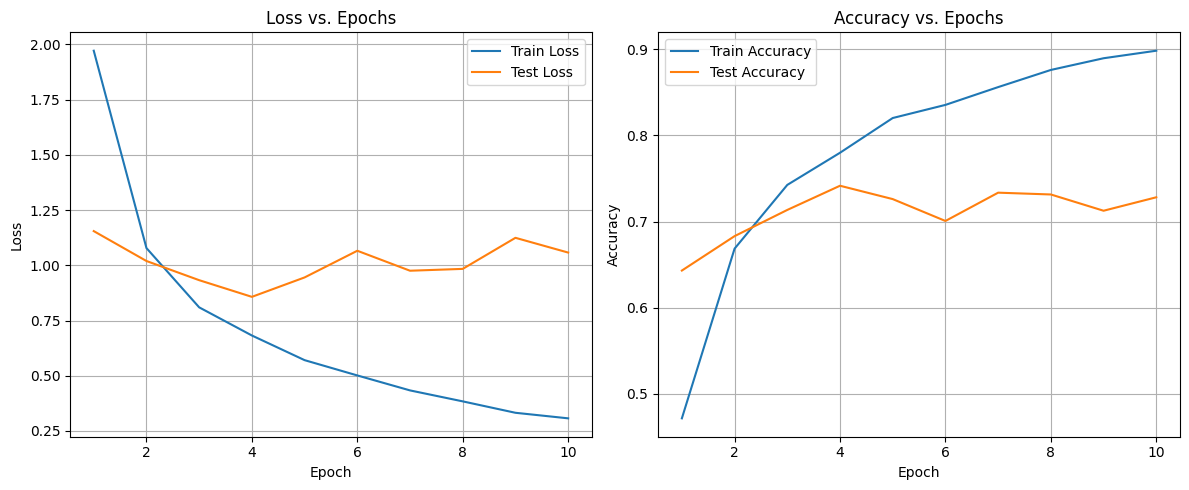

In [10]:
if train_dataloader is not None and test_dataloader is not None:
    print(f"\n학습 시작... (총 {NUM_EPOCHS} 에포크, 장치: {device})")
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
    
    epoch_pbar = tqdm(range(NUM_EPOCHS), desc="진행률", unit="epoch", leave=True) 

    for epoch in epoch_pbar:
        epoch_num_display = epoch + 1
        start_time = time.time()
        
        epoch_pbar.set_description(f"에포크 {epoch_num_display}/{NUM_EPOCHS}")
        
        train_loss, train_acc = train_one_epoch(model, train_dataloader, criterion, optimizer, device, epoch_num_display, NUM_EPOCHS, epoch_pbar)
        test_loss, test_acc = evaluate_model(model, test_dataloader, criterion, device, epoch_num_display, NUM_EPOCHS, epoch_pbar, phase_desc="Test")
        
        end_time = time.time()
        epoch_duration = end_time - start_time
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        
        epoch_pbar.set_postfix({
            'TrainLoss': f'{train_loss:.4f}', 'TrainAcc': f'{train_acc:.4f}',
            'TestLoss': f'{test_loss:.4f}', 'TestAcc': f'{test_acc:.4f}',
            'Time': f'{epoch_duration:.2f}s'
        })

    print(f"\n학습 완료! (총 {NUM_EPOCHS} 에포크)")

    if history['train_loss']:
        avg_train_loss = sum(history['train_loss']) / len(history['train_loss'])
        avg_train_acc = sum(history['train_acc']) / len(history['train_acc'])
        avg_test_loss = sum(history['test_loss']) / len(history['test_loss'])
        avg_test_acc = sum(history['test_acc']) / len(history['test_acc'])
        best_test_acc = max(history['test_acc'])

        print(f"\n--- 최종 학습 요약 ({NUM_EPOCHS} 에포크) ---")
        print(f"평균 학습 손실: {avg_train_loss:.4f}, 평균 학습 정확도: {avg_train_acc:.4f}")
        print(f"평균 테스트 손실: {avg_test_loss:.4f}, 평균 테스트 정확도: {avg_test_acc:.4f}")
        print(f"최고 테스트 정확도: {best_test_acc:.4f}")

        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(range(1, NUM_EPOCHS + 1), history['train_loss'], label='Train Loss')
        plt.plot(range(1, NUM_EPOCHS + 1), history['test_loss'], label='Test Loss')
        plt.title('Loss vs. Epochs'); plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.grid(True)
        
        plt.subplot(1, 2, 2)
        plt.plot(range(1, NUM_EPOCHS + 1), history['train_acc'], label='Train Accuracy')
        plt.plot(range(1, NUM_EPOCHS + 1), history['test_acc'], label='Test Accuracy')
        plt.title('Accuracy vs. Epochs'); plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.legend(); plt.grid(True)
        
        plt.tight_layout(); plt.show()
else:
    print("\n오류: DataLoader가 준비되지 않아 학습을 시작할 수 없습니다.")

10. 모델 가중치 저장

In [11]:
model_save_path = 'dog_breed_classifier_10_epochs.pth'
torch.save(model.state_dict(), model_save_path)
print(f"모델 가중치가 '{model_save_path}' 파일로 저장되었습니다.")

모델 가중치가 'dog_breed_classifier_10_epochs.pth' 파일로 저장되었습니다.


11. 실제 이미지로 예측 수행

학습 데이터(매핑용) 로딩 중...
품종 이름 <-> 인덱스 매핑 생성 완료.
'dog_breed_classifier_10_epochs.pth' 에서 모델 가중치를 성공적으로 불러왔습니다.

'testimg.png' 이미지에 대한 품종 예측을 시작합니다...

--- 예측 결과 ---
입력 이미지: testimg.png
예측된 품종: Border collie
신뢰도: 91.97%


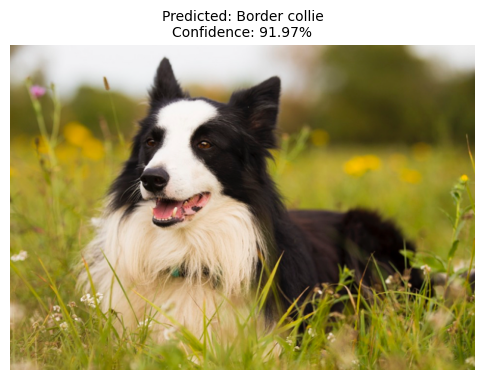

In [22]:
def create_idx_to_breed_name_mapping(df_train_data):
    idx_to_breed_name = {}
    if df_train_data is not None:
        df_mapping = df_train_data.copy()
        df_mapping['breed_folder_name_only'] = df_mapping['image_relative'].apply(lambda x: x.split('/')[0])
        unique_breeds_df = df_mapping[['label', 'breed_folder_name_only']].drop_duplicates().sort_values(by='label').reset_index(drop=True)
        for _, row in unique_breeds_df.iterrows():
            label_0_indexed = row['label'] - 1 
            breed_folder_name = row['breed_folder_name_only']
            try:
                breed_name = breed_folder_name.split('-', 1)[1].replace('_', ' ')
            except IndexError:
                breed_name = breed_folder_name.replace('_', ' ')
            idx_to_breed_name[label_0_indexed] = breed_name
        print("품종 이름 <-> 인덱스 매핑 생성 완료.")
    else:
        print("경고: df_train 데이터가 없어 품종 이름 매핑을 생성할 수 없습니다.")
    return idx_to_breed_name

def load_trained_model(model_path, num_classes, device_to_load):
    model = models.efficientnet_b0(weights=None) 
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    try:
        model.load_state_dict(torch.load(model_path, map_location=device_to_load))
        model.to(device_to_load)
        model.eval() 
        print(f"'{model_path}' 에서 모델 가중치를 성공적으로 불러왔습니다.")
        return model
    except FileNotFoundError:
        print(f"오류: 모델 파일 '{model_path}'을(를) 찾을 수 없습니다.")
        return None
    except Exception as e:
        print(f"오류: 모델 로드 중 문제 발생 - {e}")
        return None

def predict_single_image(image_path_to_predict, loaded_model, image_transforms, idx_to_name_map, device_to_use):
    try:
        img_pil = Image.open(image_path_to_predict).convert("RGB")
    except FileNotFoundError:
        print(f"오류: 이미지 파일 '{image_path_to_predict}'을(를) 찾을 수 없습니다.")
        return
    except Exception as e:
        print(f"오류: 이미지 '{image_path_to_predict}' 로드 중 에러: {e}")
        return

    try:
        img_tensor = image_transforms(img_pil)
        img_tensor = img_tensor.unsqueeze(0)
        img_tensor = img_tensor.to(device_to_use)
    except Exception as e:
        print(f"오류: 이미지 변환 중 에러: {e}")
        return

    loaded_model.eval() 
    with torch.no_grad(): 
        outputs = loaded_model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted_idx = torch.max(probabilities, 1)

    pred_label_0_indexed = predicted_idx.item()
    confidence_score = confidence.item()
    predicted_breed_name = idx_to_name_map.get(pred_label_0_indexed, f"Unknown_idx_{pred_label_0_indexed}")

    print(f"\n--- 예측 결과 ---")
    print(f"입력 이미지: {os.path.basename(image_path_to_predict)}")
    print(f"예측된 품종: {predicted_breed_name}")
    print(f"신뢰도: {confidence_score*100:.2f}%")

    plt.figure(figsize=(6,7))
    plt.imshow(img_pil) 
    plt.title(f"Predicted: {predicted_breed_name}\nConfidence: {confidence_score*100:.2f}%", fontsize=10)
    plt.axis('off')
    plt.show()

df_train_for_map = load_mat_and_create_dataframe('train_list.mat', IMAGE_BASE_PATH, ANNOTATION_BASE_PATH, LIST_BASE_PATH)
idx_to_breed_name = create_idx_to_breed_name_mapping(df_train_for_map)

model_weights_path = 'dog_breed_classifier_10_epochs.pth' 
my_trained_model = load_trained_model(model_weights_path, NUM_CLASSES, device)

if my_trained_model and idx_to_breed_name:
    new_image_file_path = 'testimg.png' # <<--- 여기에 실제 파일 경로

    if new_image_file_path and os.path.exists(new_image_file_path):
        print(f"\n'{new_image_file_path}' 이미지에 대한 품종 예측을 시작합니다...")
        if 'val_test_transforms' in locals() or 'val_test_transforms' in globals():
             predict_single_image(new_image_file_path, my_trained_model, val_test_transforms, idx_to_breed_name, device)
        else:
            print("오류: 'val_test_transforms'가 정의되지 않았습니다. 이미지 변환 규칙을 먼저 정의해주세요.")
            print("예시: ")
            print("normalize = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])")
            print("val_test_transforms = T.Compose([T.Resize((IMG_SIZE, IMG_SIZE)), T.ToTensor(), normalize])")

    elif not new_image_file_path:
        print("\n오류: 예측할 이미지 파일 경로가 지정되지 않았습니다. 'new_image_file_path' 변수를 설정해주세요.")
    else:
        print(f"\n오류: '{new_image_file_path}' 파일을 찾을 수 없습니다. 경로를 확인해주세요.")
        
elif not my_trained_model:
    print("오류: 모델 로드에 실패하여 예측을 진행할 수 없습니다.")
elif not idx_to_breed_name:
     print("오류: 품종 이름 매핑 생성에 실패하여 예측을 진행할 수 없습니다.")
